# Simulation on Orthogonal Estimation

We compare the performance of the naive and orthogonal methods in a computational experiment where
$p=n=100$, $\beta_j = 1/j^2$, $(\gamma_{DW})_j = 1/j^2$ and $$Y = 1 \cdot D + \beta' W + \epsilon_Y$$

where $W \sim N(0,I)$, $\epsilon_Y \sim N(0,1)$, and $$D = \gamma'_{DW} W + \tilde{D}$$ where $\tilde{D} \sim N(0,1)/4$.

The true treatment effect here is 1. From the plots produced in this notebook (estimate minus ground truth), we show that the naive single-selection estimator is heavily biased (lack of Neyman orthogonality in its estimation strategy), while the orthogonal estimator based on partialling out, is approximately unbiased and Gaussian.

In [1]:
# As before, we import clone hdmpy to use rlasso functions in python
!pip install multiprocess
!pip install pyreadr
!git clone https://github.com/maxhuppertz/hdmpy.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.3/144.3 kB 857.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.0/416.0 kB 6.1 MB/s eta 0:00:00
Cloning into 'hdmpy'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 70 (delta 39), reused 52 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (70/70), 25.30 KiB | 1.95 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [2]:
import hdmpy
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings
warnings.simplefilter('ignore')

In [5]:
# Initialize constants
B = 100  # Number of iterations
n = 100  # Sample size
p = 100  # Number of features

# Sim Parameters
mean = 0
sd = 1


def exp(it):
    np.random.seed(it)
    # Generate parameters:
    gamma = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)
    beta = (1 / (np.arange(1, p + 1) ** 2)).reshape(p, 1)

    # Generate covariates / random data
    X = np.random.normal(mean, sd, n * p).reshape(n, p)
    D = (X @ gamma) + np.random.normal(mean, sd, n).reshape(n, 1) / 4

    # Generate Y using DGP
    Y = D + (X @ beta) + np.random.normal(mean, sd, n).reshape(n, 1)

    # Single selection method using rlasso
    r_lasso_estimation = hdmpy.rlasso(np.concatenate((D, X), axis=1), Y, post=True)
    coef_array = r_lasso_estimation.est['coefficients'].iloc[2:, :].to_numpy()
    SX_IDs = np.where(coef_array != 0)[0]

    # Check if any X coefficients are selected
    if sum(SX_IDs) == 0:
        # If no X coefficients are selected, regress Y on D only
        Naive = sm.OLS(Y, sm.add_constant(D)).fit().params[1]
    else:
        # If X coefficients are selected, regress Y on selected X and D
        X_D = np.concatenate((D, X[:, SX_IDs]), axis=1)
        Naive = sm.OLS(Y, sm.add_constant(X_D)).fit().params[1]

    # Double Lasso Partialling Out
    fitY = hdmpy.rlasso(X, Y, post=True)
    resY = fitY.est['residuals']

    fitD = hdmpy.rlasso(X, D, post=True)
    resD = fitD.est['residuals']

    Orthogonal = sm.OLS(resY, sm.add_constant(resD)).fit().params[1]

    return Naive, Orthogonal


results = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it) for it in range(B))

Naive, Orthogonal = zip(*results)
Naive, Orthogonal = np.array(Naive), np.array(Orthogonal)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

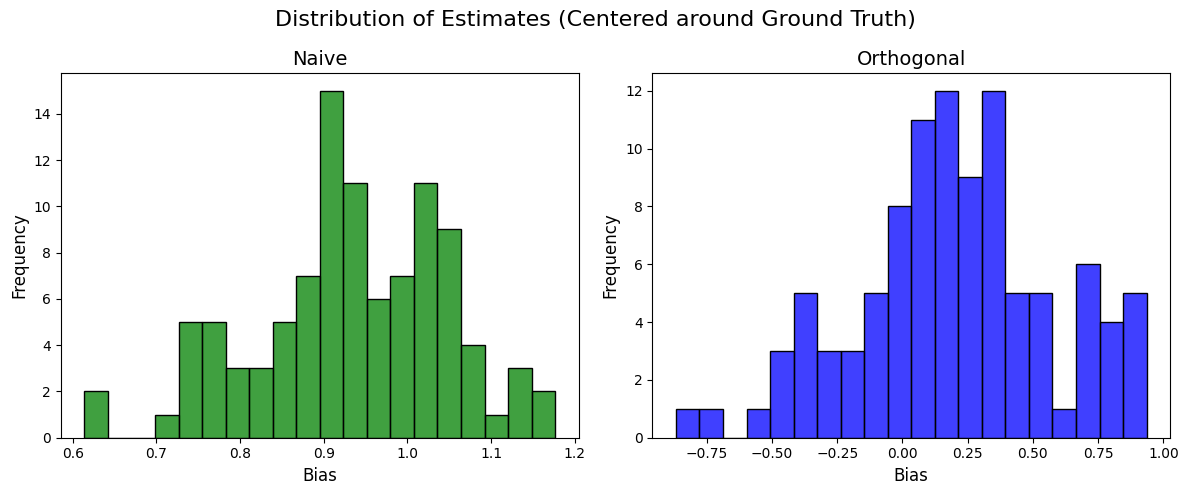

In [6]:
# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot a histogram for the 'Naive' estimates vector
sns.histplot(Naive - 1, bins=20, kde=False, color='green', ax=axes[0])
axes[1].set_title('Orthogonal', fontsize=14)
axes[1].set_xlabel('Bias', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Plot a histogram for the 'Orthogonal' estimates vector
sns.histplot(Orthogonal - 1, bins=20, kde=False, color='blue', ax=axes[1])
axes[0].set_title('Naive', fontsize=14)
axes[0].set_xlabel('Bias', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Add a title to the entire figure
fig.suptitle('Distribution of Estimates (Centered around Ground Truth)', fontsize=16)

# Display the histograms side by side
plt.tight_layout()
plt.show()

As we can see from the above bias plots (estimates minus the ground truth effect of 1), the double lasso procedure concentrates around zero whereas the naive estimator does not.


# **Summary**

The naive estimator does not account for nuisance parameters. The naive estimator could be including too many irrelevant variables, or excluding important varaibles. It is not properly isolating the causal effect.

The double lasso procedure uses 'partialling-out' to control for nuisance parameters, and orthogonally projects the treatment variable with the nuisance parameters. This allows the double lasso procedure to reduce estimator bias and center around the true effect, allowing for proper spread of variability and confidence intervals.